[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds4v/absa-vlsp-2018/blob/main/ACSA-v1/Hotel-v1.ipynb)

In [ ]:
from google.colab import drive
import os

drive.mount('/content/GoogleDrive', force_remount=True)
path = '/content/GoogleDrive/My Drive/ABSA'
os.chdir(path)
!ls

# Install & import libraries

In [ ]:
import numpy as np
import tensorflow as tf
import torch
tf.get_logger().setLevel('ERROR')
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (104.197.92.7)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by Cox - Omaha (Omaha, NE) [12.44 km]: 25.354 ms
Testing download speed................................................................................
Download: 1902.23 Mbit/s
Testing upload speed......................................................................................................
Upload: 566.64 Mbit/s


In [ ]:
!pip install -q datasets
!pip install -q transformers
!pip install -q tf-models-official

     |████████████████████████████████| 245kB 6.8MB/s 
     |████████████████████████████████| 245kB 8.3MB/s 
     |████████████████████████████████| 122kB 9.8MB/s 
     |████████████████████████████████| 2.5MB 6.7MB/s 
     |████████████████████████████████| 3.3MB 55.4MB/s 
     |████████████████████████████████| 901kB 60.4MB/s 
     |████████████████████████████████| 1.6MB 6.8MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 38.2MB 187kB/s 
     |████████████████████████████████| 358kB 61.6MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 215kB 62.7MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 686kB 54.6MB/s 
     |████████████████████████████████| 1.2MB 63.8MB/s 
     |████████████████████████████████| 645kB 60.2MB/s 


# Accelerator

## Check GPU working

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
# print('Found GPU at:', device_name)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

## Connect to the TPU worker

In [ ]:
if os.environ['COLAB_TPU_ADDR']: 
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print('Using TPU')
    print("All devices: ", tf.config.list_logical_devices('TPU'))
elif tf.test.is_gpu_available():
    strategy = tf.distribute.MirroredStrategy()
    print('Using GPU')
else: raise ValueError('Running on CPU is not recommended.')

Using TPU
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Import datasets

In [ ]:
TRAIN_PATH = 'dataset/VLSP_Hotel/hotel_train.csv'
VAL_PATH = 'dataset/VLSP_Hotel/hotel_val.csv'
TEST_PATH = 'dataset/VLSP_Hotel/hotel_test.csv'

In [ ]:
from datasets import load_dataset
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d4ac2c89f488d263/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'SERVICE#GENERAL'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACI

In [ ]:
import pandas as pd
df_train = pd.read_csv(TRAIN_PATH)
df_val = pd.read_csv(VAL_PATH)
df_test = pd.read_csv(TEST_PATH)
df_train.head(3)

,Review,FACILITIES#CLEANLINESS,FACILITIES#COMFORT,FACILITIES#DESIGN&FEATURES,FACILITIES#GENERAL,FACILITIES#MISCELLANEOUS,FACILITIES#PRICES,FACILITIES#QUALITY,FOOD&DRINKS#MISCELLANEOUS,FOOD&DRINKS#PRICES,FOOD&DRINKS#QUALITY,FOOD&DRINKS#STYLE&OPTIONS,HOTEL#CLEANLINESS,HOTEL#COMFORT,HOTEL#DESIGN&FEATURES,HOTEL#GENERAL,HOTEL#MISCELLANEOUS,HOTEL#PRICES,HOTEL#QUALITY,LOCATION#GENERAL,ROOM_AMENITIES#CLEANLINESS,ROOM_AMENITIES#COMFORT,ROOM_AMENITIES#DESIGN&FEATURES,ROOM_AMENITIES#GENERAL,ROOM_AMENITIES#MISCELLANEOUS,ROOM_AMENITIES#PRICES,ROOM_AMENITIES#QUALITY,ROOMS#CLEANLINESS,ROOMS#COMFORT,ROOMS#DESIGN&FEATURES,ROOMS#GENERAL,ROOMS#MISCELLANEOUS,ROOMS#PRICES,ROOMS#QUALITY,SERVICE#GENERAL
0,Rộng rãi KS mới nhưng rất vắng. Các dịch vụ ch...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Địa điểm thuận tiện, trong vòng bán kính 1,5km...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Phục vụ, view đẹp, vị trí",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Standardlize outputs

In [ ]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            sentiment = df.iloc[row, col]
            if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [ ]:
y_train = make_outputs(df_train)
y_val = make_outputs(df_val)
y_test = make_outputs(df_test)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[0]

Train outputs: (3000, 34, 4)
Validate outputs: (2000, 34, 4)
Test outputs: (600, 34, 4)


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

# Preprocessing 

In [ ]:
!pip install -q emoji
!pip install -q vncorenlp
!git clone https://github.com/vncorenlp/VnCoreNLP.git

     |████████████████████████████████| 133kB 6.8MB/s 
     |████████████████████████████████| 2.7MB 7.0MB/s 
Cloning into 'VnCoreNLP'...
remote: Enumerating objects: 212, done.
remote: Total 212 (delta 0), reused 0 (delta 0), pack-reused 212
Receiving objects: 100% (212/212), 214.21 MiB | 35.19 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Checking out files: 100% (33/33), done.


In [ ]:
!rm -rf teencode.txt
!wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt

--2021-07-03 15:07:09--  https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5656 (5.5K) [text/plain]
Saving to: ‘teencode.txt’

teencode.txt        100%[===================>]   5.52K  --.-KB/s    in 0.001s  

2021-07-03 15:07:10 (5.98 MB/s) - ‘teencode.txt’ saved [5656/5656]



In [ ]:
from preprocess import (
    remove_HTML, 
    convert_unicode, 
    # standardize_sentence_typing, 
    normalize_acronyms, 
    word_segmentation, # When use PhoBERT
    remove_unnecessary_characters
)

In [ ]:
def text_preprocess(text):
    text = remove_HTML(text)
    text = convert_unicode(text) 
    # text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text) # When use PhoBERT
    text = remove_unnecessary_characters(text)
    # return text.lower()
    return text

In [ ]:
#@title **Choose a pretrained model for Vietnamese that support Tensorflow from [huggingface](https://huggingface.co/transformers/pretrained_models.html)**
#@markdown
#@markdown | <h4>Model id                        </h4> | <h4>Summary                                                                              </h4> | <h4>Description                                                                                                       </h4> | <h4>Architecture</h4> |
#@markdown | ----------------------------------------- | ---------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- | --------------------- |
#@markdown | <p>vinai/phobert-base                </p> | <p>135M parameters                                                                        </p> | <p>Trained on 20GB of texts                                                                                            </p> | <p>RoBERTa       </p> |
#@markdown | <p>vinai/phobert-large               </p> | <p>370M parameters                                                                        </p> | <p>Trained on 20GB of texts                                                                                            </p> | <p>RoBERTa       </p> |
#@markdown | <p>bert-base-multilingual-uncased    </p> | <p>12-layer, 768-hidden, 12-heads, 168M parameters                                        </p> | <p>(Original, not recommended) Trained on lower-cased text in the top 102 languages with the largest Wikipedias        </p> | <p>BERT          </p> |
#@markdown | <p>bert-base-multilingual-cased      </p> | <p>12-layer, 768-hidden, 12-heads, 179M parameters                                        </p> | <p>(New, recommended) Trained on cased text in the top 104 languages with the largest Wikipedias                       </p> | <p>BERT          </p> |
#@markdown | <p>distilbert-base-multilingual-cased</p> | <p>6-layer, 768-hidden, 12-heads, 134M parameters                                         </p> | <p>The multilingual DistilBERT model distilled from the Multilingual BERT model bert-base-multilingual-cased checkpoint</p> | <p>DistilBERT    </p> |
#@markdown >

PRETRAINED_MODEL = 'vinai/phobert-base' #@param ['vinai/phobert-base', 'vinai/phobert-large', 'bert-base-multilingual-uncased','bert-base-multilingual-cased ', 'distilbert-base-multilingual-cased'] {allow-input: true}

## Tokenizing

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'vinai/phobert-base': 256, 'vinai/phobert-large': 256}

In [ ]:
# tokens = tokenizer.encode('Tôi là sinh viên trường đại học Công nghệ thông tin .') 
tokens = tokenizer.encode('Tôi là sinh_viên trường đại_học Công_nghệ thông_tin .') # When use PhoBERT
print('Encode:', tokens)
print('Decode:', tokenizer.decode(tokens))

Encode: [0, 218, 8, 649, 212, 956, 2413, 195, 5, 2]
Decode: <s> Tôi là sinh_viên trường đại_học Công_nghệ thông_tin. </s>


In [ ]:
# https://huggingface.co/transformers/preprocessing.html
def tokenize_function(dataset):
    clean_texts = list(map(text_preprocess, dataset['Review']))
    return tokenizer(clean_texts, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])


input_ids of sentence 1484: [0, 2214, 68, 14, 10, 163, 43, 107, 396, 6567, 35, 15591, 3891, 4249, 9823, 39, 1058, 445, 30, 1745, 445, 6593, 68, 320, 204, 1401, 43, 43, 1173, 320, 6, 1058, 30, 25, 77, 2903, 21, 1299, 118, 9823, 68, 437, 131, 17, 50, 292, 670, 59, 1800, 8, 68, 11, 83, 13720, 145, 7304, 6190, 1173, 1408, 13, 68, 9823, 5331, 347, 232, 68, 32, 102, 150, 320, 1299, 89, 7304, 6190, 1173, 77, 32, 17, 55, 3781, 322, 7, 86, 1398, 293, 53, 26, 117, 399, 54, 68, 108, 59, 6242, 767, 162, 26, 320, 292, 89, 601, 15, 83, 13720, 54, 76, 355, 53, 10, 1393, 30, 1855, 69, 369, 123, 249, 6, 409, 68, 979, 320, 292, 3000, 658, 570, 9133, 5848, 13503, 57, 388, 64, 17, 115, 1197, 143, 16, 777, 142, 2623, 348, 1254, 68, 30, 4249, 8, 219, 298, 471, 77, 68, 1197, 1299, 102, 13, 154, 292, 51, 26, 328, 54, 43289, 96, 8, 10, 1772, 292, 77, 13, 68, 154, 292, 236, 1254, 154, 292, 161, 68, 131, 841, 650, 533, 59, 167, 59, 1564, 24077, 3211, 4810, 2400, 4185, 103, 18335, 4767, 58, 31427, 384, 509, 3590

## Prepare for TensorFlow

In [ ]:
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
MODEL_PATH = 'ACSA-v1/Hotel'
BATCH_SIZE = 20

STEPS_PER_EPOCH = len(raw_datasets['train']) // BATCH_SIZE
VALIDATION_STEPS = len(raw_datasets['val']) // BATCH_SIZE
EPOCHS = 20

In [ ]:
def to_tensorflow_format(tokenized_dataset):
    features = tokenized_dataset.features
    return tokenized_dataset.remove_columns(list(features)[:-3]).with_format('tensorflow')

In [ ]:
from tensorflow.data import Dataset
def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=False):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf_dataset[x].to_tensor() for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)

    tf_dataset = Dataset.from_tensor_slices((features, labels))
    if shuffle: tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, y_train, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, y_val, BATCH_SIZE)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['test'],  tokenizer, y_test, BATCH_SIZE)
train_tf_dataset

<BatchDataset shapes: ({input_ids: (None, 256), token_type_ids: (None, 256), attention_mask: (None, 256)}, (None, 136)), types: ({input_ids: tf.int64, token_type_ids: tf.int64, attention_mask: tf.int64}, tf.uint8)>

# Fine-tuning with TensorFlow

## Define the model

In [ ]:
from transformers import TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

def create_model(optimizer):
    # https://riccardo-cantini.netlify.app/post/bert_text_classification
    inputs = {
        'input_ids'     : Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_ids'), 
        'token_type_ids': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='token_type_ids'), 
        'attention_mask': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='attention_mask'),
    }
    pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
    hidden_states = pretrained_bert(inputs).hidden_states

    # https://github.com/huggingface/transformers/issues/1328
    pooled_output = concatenate(
        tuple([hidden_states[i] for i in range(-4, 0)]), 
        name = 'last_4_hidden_states',
        axis = -1
    )[:, 0, :]
    x = Dropout(0.2)(pooled_output)
    print(pooled_output)

    outputs = concatenate([
        Dense(
            units = 4, 
            activation = 'softmax',
            name = label.replace('#', '-').replace('&', '_'),
        )(x) for label in df_train.columns[1:]
    ], axis = -1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

## Optimzers

In [ ]:
# from tensorflow.keras.optimizers import Adam
# optimizer = Adam(learning_rate=1e-5)
# type(optimizer)

In [ ]:
from official.nlp import optimization
num_train_steps = STEPS_PER_EPOCH * EPOCHS
optimizer = optimization.create_optimizer(
    init_lr = 2e-4, 
    num_train_steps = num_train_steps, 
    num_warmup_steps = num_train_steps // 10
)
type(optimizer)

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


official.nlp.optimization.AdamWeightDecay

## Callbacks

In [ ]:
# from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

# # Keeps initial learning rate for first 6 epochs decreases it exponentially  after that.
# def scheduler(epoch, lr):
#     if epoch < 6: return lr
#     return lr * tf.math.exp(-0.1)
# schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# # Reduce the learning rate once learning stagnates => new_lr = lr * factor. 
# reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

# Stop if no improvement after 5 epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Prevent from UnimplementedError when using TPU
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path, 
    save_best_only = True,
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH, 
    options = options,  
    verbose = 1
)

## Training

In [ ]:
with strategy.scope(): # For using TPU
    model = create_model(optimizer)
    history = model.fit(
        train_tf_dataset, 
        validation_data = val_tf_dataset, 
        validation_steps = VALIDATION_STEPS,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = EPOCHS,
        callbacks = [
            # schedule_lr_callback, # When not use AdamW
            # reduce_lr_callback, # When not use AdamW 
            early_stop_callback, 
            # checkpoint_callback
        ],
        verbose = 1,
    )
    model.save_weights(f'{MODEL_PATH}/weights.h5')

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 136) dtype=uint8>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 136) dtype=uint8>]


150/150 [==============================] - ETA: 0s - loss: 0.2586

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 136) dtype=uint8>]


150/150 [==============================] - 120s 200ms/step - loss: 0.2586 - val_loss: 0.1452
Epoch 2/20
150/150 [==============================] - 18s 118ms/step - loss: 0.1485 - val_loss: 0.1099
Epoch 3/20
150/150 [==============================] - 18s 119ms/step - loss: 0.1115 - val_loss: 0.0882
Epoch 4/20
150/150 [==============================] - 18s 119ms/step - loss: 0.0874 - val_loss: 0.0767
Epoch 5/20
150/150 [==============================] - 18s 120ms/step - loss: 0.0676 - val_loss: 0.0722
Epoch 6/20
150/150 [==============================] - 19s 124ms/step - loss: 0.0516 - val_loss: 0.0723
Epoch 7/20
150/150 [==============================] - 18s 120ms/step - loss: 0.0397 - val_loss: 0.0708
Epoch 8/20
150/150 [==============================] - 18s 120ms/step - loss: 0.0304 - val_loss: 0.0740
Epoch 9/20
150/150 [==============================] - 18s 121ms/step - loss: 0.0221 - val_loss: 0.0723
Epoch 10/20
150/150 [==============================] - 18s 119ms/step - loss: 0.016

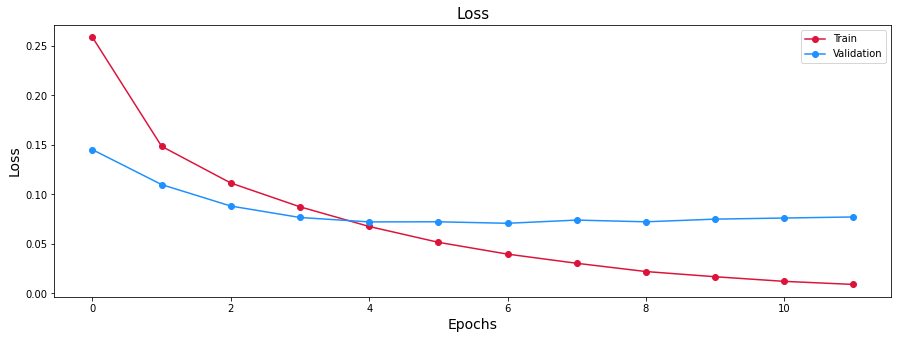

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
fig.savefig(f'{MODEL_PATH}/evaluation.png', bbox_inches='tight') 
plt.show()

## Reload the model

In [ ]:
from tensorflow.train import latest_checkpoint
with strategy.scope():
    reloaded_model = create_model(optimizer)
    # reloaded_model.load_weights(latest_checkpoint(checkpoint_dir))
    reloaded_model.load_weights(f'{MODEL_PATH}/weights.h5')
    reloaded_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf

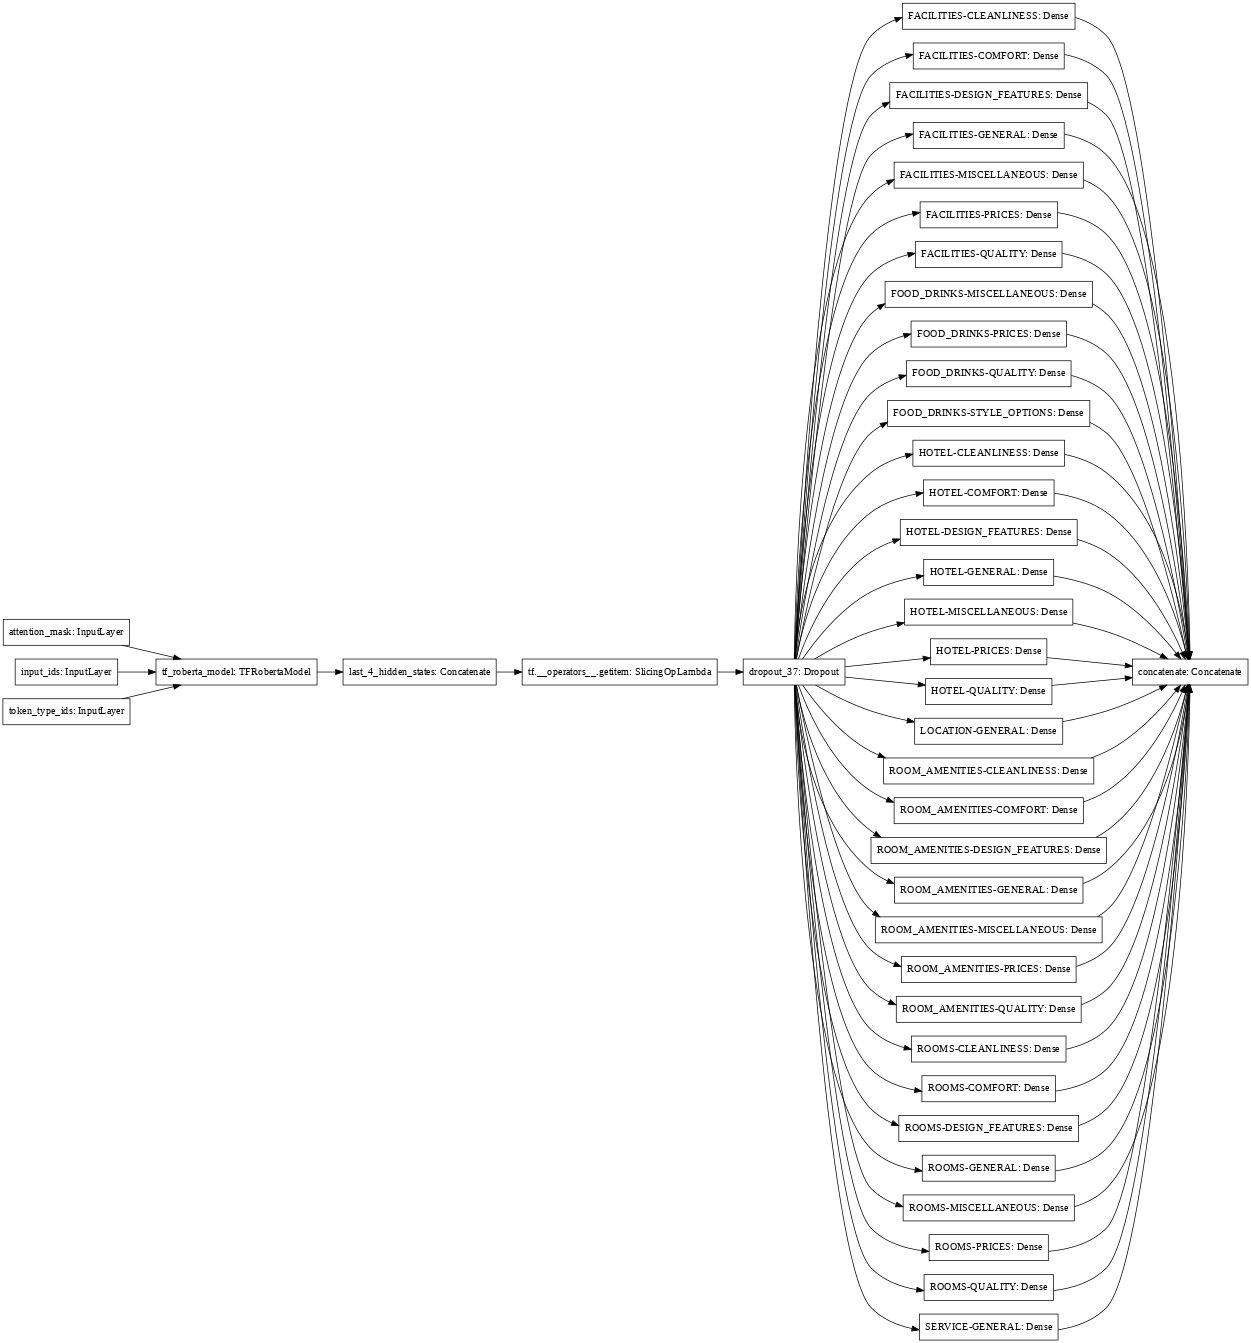

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(reloaded_model, to_file=f'{MODEL_PATH}/architecture.png', rankdir='LR', dpi=52)

# Prediction

In [ ]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_test_argmax

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

## Predict on test data

In [ ]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1) # sentiment values (position that have max value)

In [ ]:
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments): 
        if sentiment: print(f'=> {category},{sentiment}')

In [ ]:
with strategy.scope():
    y_pred = predict(reloaded_model, test_tf_dataset, BATCH_SIZE, verbose=1)
    reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 136) dtype=uint8>]


30/30 [==============================] - 11s 247ms/step


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 136) dtype=uint8>]


30/30 [==============================] - 12s 25ms/step - loss: 0.0950


In [ ]:
replacements = {0: None, 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = df_test.columns[1:]
print('Example:', df_test['Review'][0])
print_acsa_pred(replacements, categories, y_pred[0])

Example: Ga giường không sạch, nhân viên quên dọn phòng một ngày.
=> ROOM_AMENITIES#CLEANLINESS,negative
=> ROOMS#CLEANLINESS,negative
=> SERVICE#GENERAL,negative


## Predict random text

In [ ]:
example_input = text_preprocess(input('Enter your sentence: '))
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}

with strategy.scope():
    pred = predict(reloaded_model, Dataset.from_tensor_slices(features))
    print_acsa_pred(replacements, categories, pred[0])

Enter your sentence: Giá cũng ok mà nhân viên hơi thiếu chuyên nghiệp


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 256) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 256) dtype=int32>]


=> HOTEL#PRICES,positive
=> SERVICE#GENERAL,negative


# Report metrics

## Aspect Detection

In [ ]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

                                precision    recall  f1-score   support

                                   0.9689    0.9838    0.9763     17816
        FACILITIES#CLEANLINESS     1.0000    0.4000    0.5714         5
            FACILITIES#COMFORT     0.5000    0.0769    0.1333        26
    FACILITIES#DESIGN&FEATURES     0.7755    0.5846    0.6667        65
            FACILITIES#GENERAL     0.6471    0.5238    0.5789        21
      FACILITIES#MISCELLANEOUS     1.0000    0.0000    0.0000         8
             FACILITIES#PRICES     0.5455    0.4615    0.5000        13
            FACILITIES#QUALITY     0.8611    0.6078    0.7126        51
     FOOD&DRINKS#MISCELLANEOUS     1.0000    0.0000    0.0000         3
            FOOD&DRINKS#PRICES     0.7500    0.6667    0.7059         9
           FOOD&DRINKS#QUALITY     0.9516    0.9147    0.9328       129
     FOOD&DRINKS#STYLE&OPTIONS     0.9615    0.8065    0.8772       124
             HOTEL#CLEANLINESS     0.9000    0.8060    0.8504  

## Polarity Detection

In [ ]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = y_pred.flatten()
target_names = list(map(str, replacements.values()))

In [ ]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))

              precision    recall  f1-score   support

        None     0.9689    0.9838    0.9763     17816
    positive     0.8577    0.8112    0.8338      1806
    negative     0.7181    0.6202    0.6656       645
     neutral     0.6444    0.2180    0.3258       133

    accuracy                         0.9521     20400
   macro avg     0.7973    0.6583    0.7004     20400
weighted avg     0.9490    0.9521    0.9496     20400



## Aspect + Polarity

In [ ]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')

In [ ]:
aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))

                                         precision    recall  f1-score   support

            FACILITIES#CLEANLINESS,None     0.9950    1.0000    0.9975       595
        FACILITIES#CLEANLINESS,negative     1.0000    0.6667    0.8000         3
        FACILITIES#CLEANLINESS,positive     1.0000    0.0000    0.0000         2
                FACILITIES#COMFORT,None     0.9597    0.9965    0.9778       574
            FACILITIES#COMFORT,negative     1.0000    0.0000    0.0000         6
            FACILITIES#COMFORT,positive     0.5000    0.1000    0.1667        20
        FACILITIES#DESIGN&FEATURES,None     0.9510    0.9794    0.9650       535
    FACILITIES#DESIGN&FEATURES,negative     0.5000    0.5909    0.5417        22
     FACILITIES#DESIGN&FEATURES,neutral     0.0000    0.0000    0.0000         5
    FACILITIES#DESIGN&FEATURES,positive     0.7273    0.4211    0.5333        38
                FACILITIES#GENERAL,None     0.9828    0.9896    0.9862       579
            FACILITIES#GENE

## Summary

In [ ]:
aspect_dict = aspect_report['macro avg']
aspect_dict['accuracy'] = aspect_report['accuracy']

polarity_dict  = polarity_report['macro avg']
polarity_dict['accuracy'] = polarity_report['accuracy']

aspect_polarity_dict = aspect_polarity_report['macro avg']
aspect_polarity_dict['accuracy'] = aspect_polarity_report['accuracy']

In [ ]:
df_report = pd.DataFrame.from_dict([aspect_dict, polarity_dict, aspect_polarity_dict])
df_report.index = ['Aspect Detection', 'Polarity Detection', 'Aspect + Polarity']
df_report.drop('support', axis=1)

,precision,recall,f1-score,accuracy
Aspect Detection,0.822134,0.566378,0.601311,0.958333
Polarity Detection,0.797310,0.658305,0.700384,0.952059
Aspect + Polarity,0.812979,0.587939,0.581574,0.952059


# Export to VLSP format

In [ ]:
vlsp_results = []
for index, pred in enumerate(y_pred):
    sentiments = map(lambda x: replacements[x], pred)
    result = {
        'id': f'#{index + 1}',
        'text': df_test.Review[index],
        'acsa': []
    }
    for category, sentiment in zip(categories, sentiments): 
        if sentiment: result['acsa'].append('{'+ category + ', ' + sentiment + '}')
    vlsp_results.append(result)
vlsp_results[:3]

[{'acsa': ['{ROOM_AMENITIES#CLEANLINESS, negative}',
   '{ROOMS#CLEANLINESS, negative}',
   '{SERVICE#GENERAL, negative}'],
  'id': '#1',
  'text': 'Ga giường không sạch, nhân viên quên dọn phòng một ngày.'},
 {'acsa': ['{LOCATION#GENERAL, positive}',
   '{ROOMS#CLEANLINESS, positive}',
   '{ROOMS#COMFORT, positive}',
   '{SERVICE#GENERAL, positive}'],
  'id': '#2',
  'text': 'Nv nhiệt tình, phòng ở sạch sẽ, tiện nghi, vị trí khá thuận tiện cho việc di chuyển đến các địa điểm ăn + chơi Phòng có gián'},
 {'acsa': ['{LOCATION#GENERAL, positive}',
   '{ROOMS#DESIGN&FEATURES, neutral}',
   '{ROOMS#GENERAL, positive}'],
  'id': '#3',
  'text': 'Đi bộ ra biển gần, tiện đi lại Phòng view biển nhưng cửa sổ view biển khá bé'}]

In [ ]:
with open('ACSA-v1-hotel.txt', 'w', encoding='utf-8') as f:
    for result in vlsp_results:
        id, text, acsa = result.values()
        f.write(f"{id}\n{text}\n{', '.join(acsa)}\n\n")

In [ ]:
import gc
del model
torch.cuda.empty_cache()
gc.collect()

15034